# Characteristic Functions Methods Approximating CDF/PDF

- Methods implemented are based on foundational research from {cite:p}`FangOst2008`.

This work builds upon advanced coursework in computational finance under Dr. Fang Fang from TU Delft.

- If characteristic function is known then we can use characteristic functions (ch.f.) methods to approximate CDF and PDF. We define characteristic function of a random variable $X$ as

    $$ \varphi_X(t) = \mathbb{E}[e^{itx}] = \int_{-\infty}^{+\infty} e^{itx}f_X(x) \, \mathrm{d}x. $$

    where $i$ represents the imaginary unit.

- $F_X(x)$, the cumualative distribution function (CDF) of $X$ completely determines the characteristic function $\varphi_X(x)$; and vice versa.

    - i.e. if $X$ admist a probability density function (PDF) $f_X(x)$, then $\varphi_X(x)$ is its **Fourier dual**, in the sense that $f_X(x)$ and $\varphi_X(x)$ are the **continuous Fourier transforms** of each other.


- The inversion formula; going from characteristic function to pdf
    $$ f_X(x) = \frac{1}{2\pi}\int_{-\infty}^{+\infty} e^{-itx}\varphi_X(t) \, \mathrm{d}t. $$

- If ch.f. of an option pricing model is known analytically or semi-analytically - for example Black-Scholes, Heston, Variance-Gamme process, Affine jump diffusion processes in general. Then, these ch.f. based methods can offer an efficient way of computing PDF by inverting the ch.f., and thus option price.

- Having the corresponding PDF it allows us to price the options, i.e. computing the following integral under risk-neutral probability measure $\mathbb{Q}$:

$$ v(x, t_0) = e^{-r\Delta t} \mathbb{E}^{\mathbb{Q}}[v(y, T) \, | \, x ] = e^{-r\Delta t} \int_\mathbb{R} v(y, T) f(y \mid x) \, \mathrm{d}y  $$

## TO DO:
1 - Add a summary table
    

In [66]:
# Import libraries
import numpy as np
import matplotlib.pyplot as plt
import time
import scipy as ss
from scipy.stats import norm
from scipy.integrate import trapezoid
import pandas as pd

## COS method

- The COS method (see [Fang-Osterlee 2009](http://ta.twi.tudelft.nl/mf/users/oosterle/oosterlee/COS.pdf)) is highly efficient semi-analyitcal algorithm to solve the expectation of a function of a random variable.

- Unlike FFT, COS does not require any numerical integration, thus is much faster.

- For a smooth function supported on a finite interval $[a,b]$, the Fourier cosine expansion is

    $$ f(x) = \frac{1}{2}A_0 + \sum^{+\infty}_{k=1} A_k \cdot \cos\left(k \pi \frac{x-a}{b-a}\right)$$

    - So we will assume that we can make a periodic extension of the target function $f$, by choosing an interval $[a,b]$ such that we capture the the function "well enough".
    
- Coefficients $A_k$'s can be directly sampled from the Fourier transform of $f(x)$.
    
    $$A_k = \frac{2}{b-a}\mathfrak{Re}\left\{ \varphi\left( \frac{k\pi}{b-a} \right)\cdot \exp\left(-i\frac{k\pi a}{b-a}\right)  \right\} $$

where $\varphi(x) = \int^a_b e^{itx}f(x) \, \mathrm{d}x$

- For a smooth probability densities $f(x)$ supported on $(-\infty, +\infty)$ we can truncate the distribution on a large enough interval $[a, b]$ and replace $\varphi$ in the definition of $A_k$'s by the characteristic function of $f(x)$ as an accurate approximation.
- COS method is proved to converge exponentially for regular densities.


To demonstrate each this,
- we evaluate the equation $f(x) = \frac{1}{\sqrt{2\pi}}e^{-1/2x^2}$,
- we determine the accuracy for different values of $N$ - number of integration points,
- we choose interval $[-10, 10]$,
- measure the error  at $x = \{-5, -4, \ldots, 4, 5 \}$.

In [67]:
# Recovery CDF
def cos_cdf(a, b, omega, chf, x):
    # F_k coefficients
    F_k = 2.0 / (b - a) * np.real(chf * np.exp(-1j * omega * a))
    cdf = np.squeeze(F_k[0] / 2.0 * (x - a)) + np.matmul(F_k[1:] / omega[1:], np.sin(np.outer(omega[1:], x - a)))
    
    return cdf

# Recover PDF
def cos_pdf(a, b, omega, chf, x): 
    # F_k coefficients
    F_k = 2.0 / (b - a) * np.real(chf * np.exp(-1j * omega * a))
    # Separate first term and remaining terms like in cos_cdf
    pdf = F_k[0] / 2.0 + np.matmul(F_k[1:], np.cos(np.outer(omega[1:], x - a)))
    
    return pdf

def cos_pdf2(a, b, N, chf, x): # chf(omega)
    #i = np.complex(0.0, 1.0)  # assigning i=sqrt(-1)
    k = np.linspace(0, N-1, N)
    #u = np.zeros([1,N]) # Num of arguments for ch.f.
    u = k * np.pi / (b-a) # scale; frequencies -- u = omega 
    # F_k coefficients
    F_k = 2.0 / (b - a) * np.real(chf(u) * np.exp(-1j * u * a))
    F_k[0] = F_k[0] * 0.5  # first term
    # Final calculation
    pdf = np.matmul(F_k, np.cos(np.outer(u, x - a)))
    
    return pdf


Convergence table:


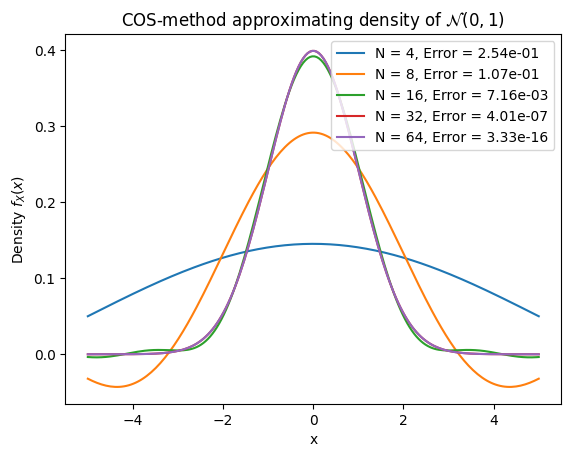

    N         Error  CPU time (msec.)  Diff. in CPU (msec.)
0   4  2.536344e-01          0.026178                   NaN
1   8  1.074376e-01          0.037193              0.011015
2  16  7.158203e-03          0.021410             -0.015783
3  32  4.008963e-07          0.037527              0.016117
4  64  3.330669e-16          0.078630              0.041103

Testing CDF recovery:


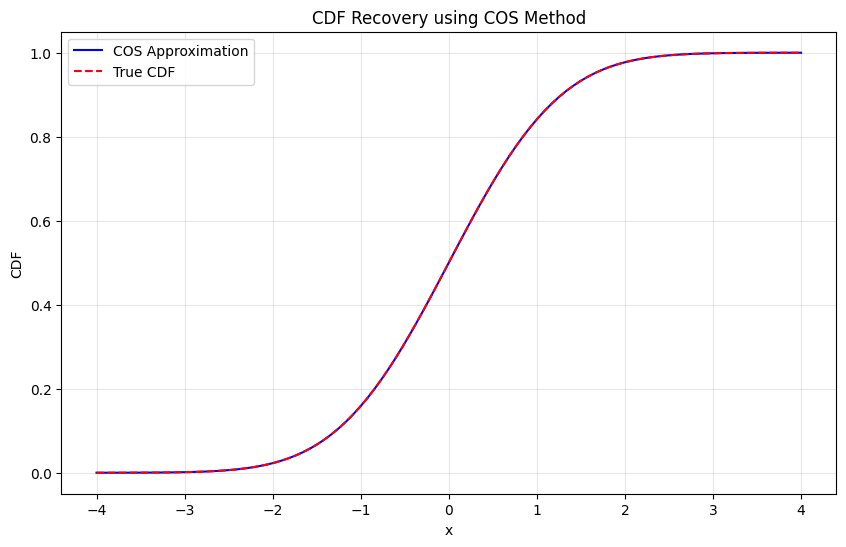

Maximum CDF error: 5.55e-16


In [68]:
# Test
def generate_cos_convergence_analysis():
    """ Make a plot & table of error convergence of COS method for approximating PDF of standard normal 
    """
    # Define characteristic function of standard normal
    def chf_normal(omega):
        return np.exp(-0.5 * omega**2)
    
    # Setup test parameters
    a, b = -10, 10                   # Domain boundaries
    x = np.linspace(-5, 5, 200)      # Points to evaluate
    exact_pdf = norm.pdf(x)          # Exact pdf to match
    N_values = [4, 8, 16, 32, 64]    # Number of terms to test
    
    # Initialise vectors
    errors = []
    cpu_times = []
    diff_cpu_times = []
        
    prev_time = 0
    
    # Test each value of N
    for N in N_values:
        # Compute frequencies (omega) for this N
        k = np.linspace(0, N-1, N)
        omega = k * np.pi / (b - a)
        
        # Pre-compute characteristic function values
        chf_values = chf_normal(omega)
        
        # Measure CPU time correctly
        times = []
        for _ in range(10):  # Run more times for more stable timing
            start = time.time()
            # Use the new cos_pdf signature with pre-computed values
            cos_pdf_values = cos_pdf(a, b, omega, chf_values, x)
            end = time.time()
            times.append((end - start) * 1000)  # Convert to milliseconds
        
        cpu_time = np.mean(times)
        
        # Calculate maximum error
        error = np.max(np.abs(cos_pdf_values - exact_pdf))
        
        # Calculate difference in CPU time
        diff_time = cpu_time - prev_time if N != 4 else 0
        
        # Store results
        errors.append(error)
        cpu_times.append(cpu_time)
        diff_cpu_times.append(diff_time if N != 4 else None)  # Set first row = None
        
        prev_time = cpu_time
    
        # Plot of the approximations
        plt.plot(x, cos_pdf_values, label=f'N = {N}, Error = {error:.2e}')
    
    plt.title("COS-method approximating density of $\mathcal{N}(0,1)$")
    plt.xlabel("x")
    plt.ylabel("Density $f_X(x)$")
    plt.legend()  
    plt.show()
    
    # Create a pandas DataFrame
    results_df = pd.DataFrame({
        'N': N_values,
        'Error': errors,
        'CPU time (msec.)': cpu_times,
        'Diff. in CPU (msec.)': diff_cpu_times
    })
    return results_df

# Test COS CDF recovery
def test_cos_cdf():
    """ Test CDF recovery for standard normal """
    def chf_normal(u): 
        return np.exp(-0.5 * u**2)
    
    x_vals = np.linspace(-4, 4, 100)
    
    # Recover CDF
    a, b, = -8.0, 8.0
    N = 2**12
    k_values = np.arange(N)
    omega = k_values * np.pi / (b - a)
    chf_values = chf_normal(omega)
    
    cdf_approx = cos_cdf(a, b, omega, chf_values, x_vals)
    
    # True CDF
    cdf_true = norm.cdf(x_vals)
    
    # Plot comparison
    plt.figure(figsize=(10, 6))
    plt.plot(x_vals, cdf_approx, 'b-', label='COS Approximation')
    plt.plot(x_vals, cdf_true, 'r--', label='True CDF')
    plt.title("CDF Recovery using COS Method")
    plt.xlabel("x")
    plt.ylabel("CDF")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()
    
    # Report error
    max_error = np.max(np.abs(cdf_approx - cdf_true))
    print(f"Maximum CDF error: {max_error:.2e}")

# Run tests
if __name__ == "__main__":    
    print("\nConvergence table:")
    print(generate_cos_convergence_analysis()) # includes the plot
    
    print("\nTesting CDF recovery:")
    test_cos_cdf()

## Carr-Madan method

To demonstrate each this,
- we evaluate the equation $f(x) = \frac{1}{\sqrt{2\pi}}e^{-1/2x^2}$,
- we determine the accuracy for different values of $N$ - number of integration points,
- we choose interval $[-10, 10]$,
- measure the error  at $x = \{-5, -4, \ldots, 4, 5 \}$.

In [69]:
N_values = [16, 32, 64, 128, 256, 512]

In [70]:
# Recover CDF
def carr_madan_cdf(chf, x_grid, u_max=200, N=2**12):
    """
    Recover CDF from characteristic function using Gil-Pelaez inversion formula.
    Parameters:
    - chf: function, characteristic function phi(u)
    - x_grid: np.array, evaluation points for CDF
    - u_max: upper frequency limit (increased for better tail accuracy)
    - N: number of frequency discretization points (increased for better resolution)
    Returns:
    - cdf: np.array, CDF values at x_grid
    """
    # Starting from close to 0
    u_min = 1e-10  # Much smaller starting point to capture low-frequency behavior
    u = np.linspace(u_min, u_max, N)
    
    # Compute integrand for each x (unchanged)
    integrand = np.imag(np.exp(-1j * np.outer(x_grid, u)) * chf(u)) / u  # shape: (len(x), N)
    
    # Integrate using trapezoidal rule along frequency axis (unchanged)
    integral = trapezoid(integrand, u, axis=1)
    
    # Apply Gil-Pelaez inversion formula
    cdf = 0.5 - (1 / np.pi) * integral
    
    return np.clip(np.squeeze(cdf), 0.0, 1.0)  # Clamp in [0,1]

# Recover PDF
def carr_madan_pdf(chf, x_grid, u_max=200, N=2**12):
    """
    Recover PDF using Carr-Madan method (Inverse Fourier Transform)

    Parameters:
    - chf: function, characteristic function φ(u)
    - x_grid: np.array, points where to compute the PDF
    - u_max: upper bound for frequency domain
    - N: number of discretization points (power of 2 for FFT)

    Returns:
    - pdf: np.array, PDF values at each x in x_grid
    """
    du = 2 * u_max / N
    u = np.linspace(-u_max, u_max - du, N)
    
    # Compute integrand of inverse Fourier transform
    integrand = np.exp(-1j * np.outer(x_grid, u)) * chf(u)
    
    # Numerical integration using trapezoidal rule
    integral = trapezoid(integrand, u, axis=1)
    
    pdf = np.squeeze(np.real(integral) / (2 * np.pi))
    return pdf


In [71]:
def carr_madan_pdf(chf, x_range=(-5, 5), N=2**12, alpha=0.0):
    x_min, x_max = x_range
    L = x_max - x_min
    dx = L / N
    du = 2*np.pi / L

    # Build symmetric frequency grid compatible with FFT ordering
    # Use np.fft.fftfreq to avoid off-by-one mishaps, then scale & shift.
    k = np.fft.fftfreq(N, d=dx)  # cycles per unit x
    u = 2*np.pi * k               # angular frequencies
    # Put into "FFT input order": DC at index 0, positives up, then negatives
    # u returned by fftfreq is already in that order; for explicit symmetry handling:
    # (no shift needed for input to np.fft.fft)
    
    # Real-space grid in the desired interval
    x = x_min + np.arange(N) * dx

    # Damping (optional): evaluate at u - i*alpha
    if alpha and alpha != 0.0:
        phi = chf(u - 1j*alpha)
    else:
        phi = chf(u)

    # Phase to anchor the transform at x_min
    integrand = phi * np.exp(-1j * u * x_min)

    # FFT of the frequency samples
    F = np.fft.fft(integrand)

    # Scale and undamp
    pdf = (du / (2*np.pi)) * np.real(F)
    if alpha and alpha != 0.0:
        pdf *= np.exp(-alpha * x)

    return x, pdf



Convergence plot and table:


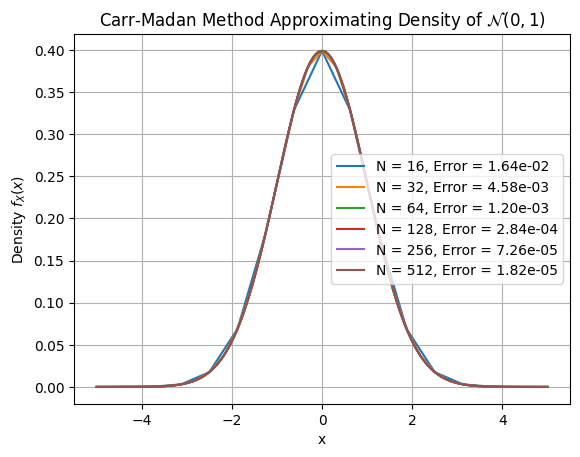

     N     Error  CPU time (msec.)  Diff. in CPU (msec.)
0   16  0.016351          0.053930                   NaN
1   32  0.004577          0.044441             -0.009489
2   64  0.001203          0.043058             -0.001383
3  128  0.000284          0.019836             -0.023222
4  256  0.000073          0.023985              0.004148
5  512  0.000018          0.040531              0.016546

Testing CDF recovery:


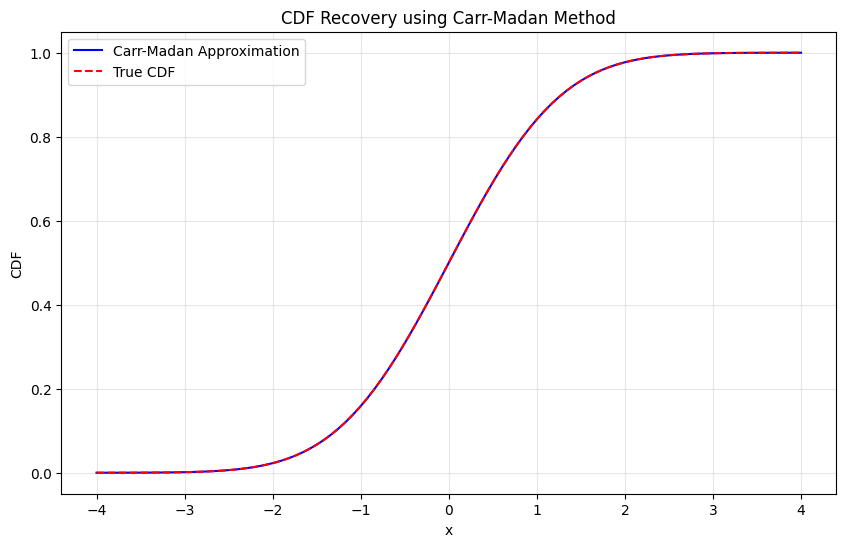

Maximum CDF error: 1.27e-10


In [72]:
# Test Carr-Madan
def generate_carr_madan_convergence_analysis():
    """ Make a plot & table of error convergence for Carr-Madan method approximating PDF of standard normal """
    def chf_normal(u):
        return np.exp(-0.5 * u**2)
    
    x = np.linspace(-5, 5, 200)
    exact_pdf = norm.pdf(x)
    #N_values = [16, 32, 64, 128, 256, 512]  # FFT sizes
    
    errors = []
    cpu_times = []
    diff_cpu_times = []
    
    prev_time = 0
    
    for N in N_values:
        times = []
        for _ in range(5):  # Run a few times for stability
            start = time.time()
            x_cm, pdf_vals_cm = carr_madan_pdf(chf_normal, x_range=(-5, 5), N=N)
            pdf_vals = np.interp(x, x_cm, pdf_vals_cm)
            end = time.time()
            times.append((end - start) * 1000)  # ms
        
        cpu_time = np.mean(times)
        error = np.max(np.abs(pdf_vals - exact_pdf))
        diff_time = cpu_time - prev_time if N != N_values[0] else 0
        
        errors.append(error)
        cpu_times.append(cpu_time)
        diff_cpu_times.append(diff_time if N != N_values[0] else None)
        
        prev_time = cpu_time
        
        # Plot
        plt.plot(x, pdf_vals, label=f'N = {N}, Error = {error:.2e}')
    
    plt.title("Carr-Madan Method Approximating Density of $\mathcal{N}(0,1)$")
    plt.xlabel("x")
    plt.ylabel("Density $f_X(x)$")
    plt.legend()
    plt.grid(True)
    plt.show()
    
    results_df = pd.DataFrame({
        'N': N_values,
        'Error': errors,
        'CPU time (msec.)': cpu_times,
        'Diff. in CPU (msec.)': diff_cpu_times
    })
    
    return results_df

# Test Carr-Madan CDF recovery
def test_carr_madan_cdf():
    """ Test CDF recovery for standard normal """
    def chf_normal(u): 
        return np.exp(-0.5 * u**2)
    
    x_vals = np.linspace(-4, 4, 100)
    
    # Recover CDF
    cdf_approx = carr_madan_cdf(chf_normal, x_vals, N=2**12)
    
    # True CDF
    cdf_true = norm.cdf(x_vals)
    
    # Plot comparison
    plt.figure(figsize=(10, 6))
    plt.plot(x_vals, cdf_approx, 'b-', label='Carr-Madan Approximation')
    plt.plot(x_vals, cdf_true, 'r--', label='True CDF')
    plt.title("CDF Recovery using Carr-Madan Method")
    plt.xlabel("x")
    plt.ylabel("CDF")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()
    
    # Report error
    max_error = np.max(np.abs(cdf_approx - cdf_true))
    print(f"Maximum CDF error: {max_error:.2e}")
    
# Run tests
if __name__ == "__main__":    
    print("\nConvergence plot and table:")
    print(generate_carr_madan_convergence_analysis()) # includes the plot
    
    print("\nTesting CDF recovery:")
    test_carr_madan_cdf()

## CONV method

To demonstrate each this,
- we evaluate the equation $f(x) = \frac{1}{\sqrt{2\pi}}e^{-1/2x^2}$,
- we determine the accuracy for different values of $N$ - number of integration points,
- we choose interval $[-10, 10]$,
- measure the error  at $x = \{-5, -4, \ldots, 4, 5 \}$.

Testing PDF recovery:


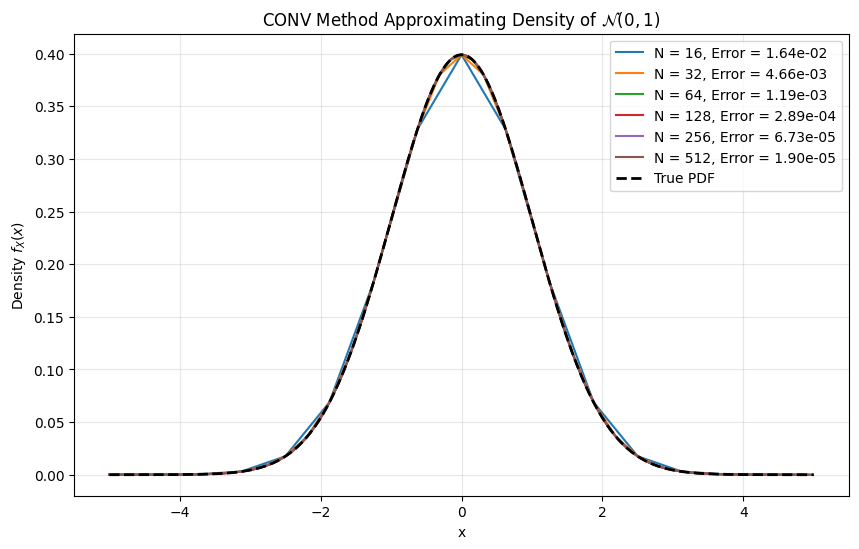


Convergence table:
     N     Error  CPU time (msec.)  Diff. in CPU (msec.)
0   16  0.016413          0.048685                   NaN
1   32  0.004663          0.037622             -0.011063
2   64  0.001192          0.038123              0.000501
3  128  0.000289          0.041389              0.003266
4  256  0.000067          0.046492              0.005102
5  512  0.000019          0.122571              0.076079

Testing CDF recovery:


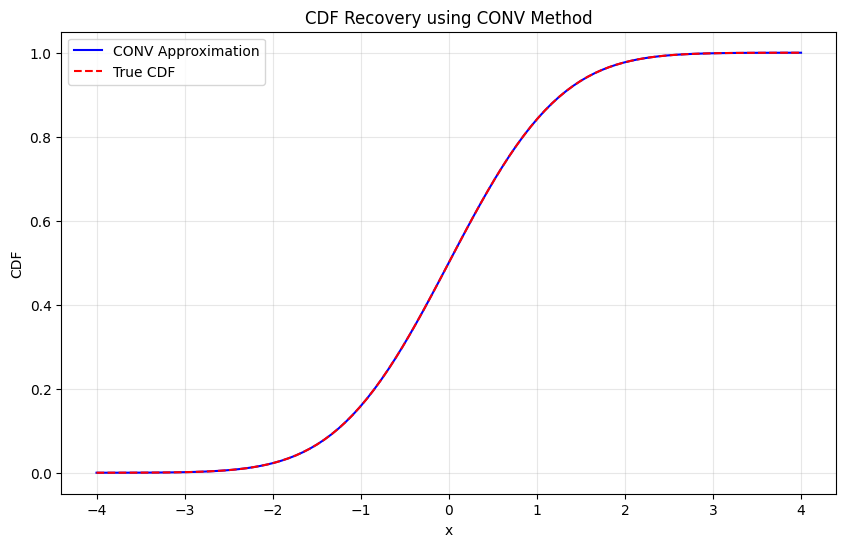

Maximum CDF error: 7.56e-07


In [73]:
def conv_pdf(chf, x_range=(-5, 5), alpha=0.0, N=2**12):
    """
    CONV method for PDF recovery using FFT
    
    This implementation carefully handles the discrete approximation of:
    f(x) = (1/2pi) \int phi(u-ia) e^{-iux} du
    
    The key insights:
    1. The FFT computes a discrete approximation to the continuous Fourier transform
    2. We must carefully align the frequency and spatial grids
    3. The damping factor 'alpha'(denote as a in comments) ensures numerical stability
    
    Parameters:
    - chf: characteristic function phi(u)
    - x_range: tuple (x_min, x_max) for the output domain
    - alpha: damping factor (positive for stability)
    - N: number of FFT points (power of 2 recommended)
    
    Returns:
    - x: real-space grid
    - pdf: corresponding recovered PDF values
    """
    
    # Step 1: Set up the grids
    x_min, x_max = x_range
    L = x_max - x_min  # Total length of spatial domain
    
    # Spatial and frequency grid spacings
    dx = L / N
    du = 2 * np.pi / L
    
    # Step 2: Create the frequency grid
    # For FFT, we need frequencies from -u_max to u_max where u_max = pi/dx
    # But FFT expects a specific ordering
    u_max = np.pi / dx  # Nyquist frequency
    
    # Create frequency array in "standard" order from -u_max to u_max
    if N % 2 == 0:
        # For even N: [-N/2, -N/2+1, ..., -1, 0, 1, ..., N/2-1] x du
        k = np.concatenate([np.arange(-N//2, 0), np.arange(0, N//2)])
    else:
        # For odd N: [-(N-1)/2, ..., -1, 0, 1, ..., (N-1)/2] x du
        k = np.arange(-(N-1)//2, (N+1)//2)
    
    u = k * du
    
    # Step 3: Create the spatial grid
    # Important: This grid corresponds to the FFT output ordering
    x = x_min + np.arange(N) * dx
    
    # Step 4: Evaluate the damped characteristic function
    # phi(u - ia) provides exponential damping for numerical stability
    phi_damped = chf(u - 1j * alpha)
    
    # Step 5: Prepare the integrand for FFT
    # We need to include a phase factor to account for the shift to x_min
    # The continuous transform of phi(u)e^{-iu x_min} gives f(x + x_min)
    integrand = phi_damped * np.exp(-1j * u * x_min)
    
    # Step 6: Apply FFT with correct ordering
    # FFT expects input in order [0, 1, ..., N/2-1, -N/2, ..., -1]
    # So we need to reorder our frequency-domain data
    integrand_fft_order = np.fft.ifftshift(integrand)
    
    # Step 7: Compute the FFT
    # This approximates the integral \int{ phi(u-ia) e^{-iu(x-x_min)} du }
    fft_result = np.fft.fft(integrand_fft_order)
    
    # Step 8: Extract and normalize the PDF
    # The factor du converts the sum to an integral
    # The factor 1/(2pi) comes from the inverse Fourier transform
    # The factor e^{-ax} removes the damping we introduced
    pdf = np.real(fft_result) * np.exp(-alpha * x) * du / (2 * np.pi)
    
    # Step 9: Ensure non-negativity (small numerical errors can cause negative values)
    pdf = np.maximum(pdf, 0)
    
    # Check: Normalize to ensure integral equals 1
    integral = trapezoid(pdf, x)
    if integral > 0:
        pdf = pdf / integral
    
    return x, pdf

def conv_cdf(chf, x_vals, x_range=None, alpha=0.0, N=2**13):
    """
    Recover CDF directly from characteristic function by integrating the recovered PDF.
    
    This approach:
    1. Uses conv_pdf() to recover the PDF from the characteristic function
    2. Numerically integrates the PDF to get the CDF
    
    Parameters:
    - chf: characteristic function φ(u)
    - x_vals: array of x values where we want to evaluate the CDF
    - x_range: tuple (x_min, x_max) for PDF recovery domain
               If None, automatically determined from x_vals with padding
    - alpha: damping factor for PDF recovery (default 0.5)
    - N: number of FFT points for PDF recovery (default 2^13)
    
    Returns:
    - cdf_vals: CDF values at the requested x_vals points
    """
    
    # Step 1: Determine the domain for PDF recovery
    if x_range is None:
        # Automatically choose a domain that covers x_vals with some padding
        # This ensures we capture the full probability mass
        x_min_req = np.min(x_vals)
        x_max_req = np.max(x_vals)
        padding = (x_max_req - x_min_req) * 0.5  # 50% padding on each side
        x_range = (x_min_req - padding, x_max_req + padding)
    
    # Step 2: Recover the PDF using our existing function
    x_grid, pdf_grid = conv_pdf(chf=chf, x_range=x_range, alpha=alpha, N=N)
    
    # Step 3: Compute CDF on the native grid by cumulative integration
    # Using the trapezoidal rule for integration
    dx = x_grid[1] - x_grid[0]  # Grid spacing (uniform)
    cdf_grid = np.zeros_like(pdf_grid)
    
    # Integrate from left to right: CDF[i] = \int_{-\infty}^{x[i]} PDF(t) dt
    cdf_grid[0] = 0.0  # CDF starts at 0 at the leftmost point
    for i in range(1, len(cdf_grid)):
        # Add the area of the trapezoid between points i-1 and i
        cdf_grid[i] = cdf_grid[i-1] + 0.5 * (pdf_grid[i-1] + pdf_grid[i]) * dx
    
    # Alternative vectorized approach (more efficient):
    # cdf_grid = np.concatenate([[0], np.cumsum(0.5 * (pdf_grid[:-1] + pdf_grid[1:]) * dx)])
    
    # Step 4: Interpolate CDF to the requested x_vals
    cdf_vals = np.interp(x_vals, x_grid, cdf_grid)
    
    # Step 5: Ensure CDF properties are satisfied
    # CDF should be between 0 and 1, and monotonically increasing
    cdf_vals = np.clip(cdf_vals, 0.0, 1.0)
    
    return cdf_vals

def conv_cdf_GP(chf, x_vals, u_max=100, N=2**13):
    """ Recover CDF using Gil-Pelaez inversion formula
        CDF(x) = 1/2 - (1/pi) \int_0^\infty Im[e^(-iux)phi(u)]/u du """
    # Use positive u only (integrand is odd in u)
    du = u_max / N
    u = np.linspace(du, u_max, N)  # avoid u=0 singularity
    
    # Vectorized computation for all x values
    integrand = np.imag(np.exp(-1j * np.outer(x_vals, u)) * chf(u)) / u
    
    # Integrate over u for each x
    integral = trapezoid(integrand, u, axis=1)
    
    # Apply inversion formula
    cdf = 0.5 - (1 / np.pi) * integral
    
    return np.clip(cdf, 0.0, 1.0)


# Test functions
def plot_conv_pdf_convergence():
    """ Test PDF recovery with standard normal distribution """
    def chf_normal(u): 
        return np.exp(-0.5 * u**2)
    
    x_true = np.linspace(-5, 5, 500)
    exact_pdf = norm.pdf(x_true)
    
    plt.figure(figsize=(10, 6))
    
    # Store errors for the table
    results = []
    
    for N in N_values:
        # Use fixed domain and moderate damping
        x, pdf = conv_pdf(chf=chf_normal, x_range=(-5, 5), alpha=0.0, N=N)
        
        # Interpolate to common grid for comparison
        interp_pdf = np.interp(x_true, x, pdf)
        error = np.max(np.abs(interp_pdf - exact_pdf))
        
        plt.plot(x, pdf, label=f'N = {N}, Error = {error:.2e}')
        results.append((N, error))
    
    plt.plot(x_true, exact_pdf, 'k--', linewidth=2, label='True PDF')
    plt.title("CONV Method Approximating Density of $\mathcal{N}(0,1)$")
    plt.xlabel("x")
    plt.ylabel("Density $f_X(x)$")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()
    
    return results


def generate_conv_convergence_table():
    """ Generate convergence table with timings """
    def chf_normal(u): 
        return np.exp(-0.5 * u**2)
    
    # Create a common reference grid for fair comparison
    x_true = np.linspace(-5, 5, 500)
    true_pdf = norm.pdf(x_true)
    
    errors = []
    cpu_times = []
    diff_cpu_times = []
    prev_time = 0
    
    for N in N_values:
        # Time multiple runs for accuracy
        times = []
        for _ in range(10):
            start = time.time()
            x, pdf = conv_pdf(chf=chf_normal, x_range=(-5, 5), alpha=0.0, N=N)
            end = time.time()
            times.append((end - start) * 1000)
        
        avg_time = np.mean(times)
        
        # Interpolate to common grid before computing error
        interp_pdf = np.interp(x_true, x, pdf)
        error = np.max(np.abs(interp_pdf - true_pdf))
        
        # Time difference
        delta_time = avg_time - prev_time if N != N_values[0] else None
        
        errors.append(error)
        cpu_times.append(avg_time)
        diff_cpu_times.append(delta_time)
        prev_time = avg_time
    
    table = pd.DataFrame({
        'N': N_values,
        'Error': errors,
        'CPU time (msec.)': cpu_times,
        'Diff. in CPU (msec.)': diff_cpu_times
    })
    
    return table

# Test CDF recovery
def test_conv_cdf():
    """ Test CDF recovery for standard normal """
    def chf_normal(u): 
        return np.exp(-0.5 * u**2)
    
    x_vals = np.linspace(-4, 4, 100)
    
    # Recover CDF
    cdf_approx = conv_cdf(chf_normal, x_vals, alpha=0.5, N=2**12)
    
    # True CDF
    cdf_true = norm.cdf(x_vals)
    
    # Plot comparison
    plt.figure(figsize=(10, 6))
    plt.plot(x_vals, cdf_approx, 'b-', label='CONV Approximation')
    plt.plot(x_vals, cdf_true, 'r--', label='True CDF')
    plt.title("CDF Recovery using CONV Method")
    plt.xlabel("x")
    plt.ylabel("CDF")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()
    
    # Report error
    max_error = np.max(np.abs(cdf_approx - cdf_true))
    print(f"Maximum CDF error: {max_error:.2e}")


# Run tests
if __name__ == "__main__":
    print("Testing PDF recovery:")
    plot_conv_pdf_convergence()
    
    print("\nConvergence table:")
    print(generate_conv_convergence_table())
    
    print("\nTesting CDF recovery:")
    test_conv_cdf()

In [76]:
def summary_convergence_table():
    """ Generate convergence table with timings """
    def chf_normal(u): 
        return np.exp(-0.5 * u**2)
    
    # Create a common reference grid for fair comparison
    x_true = np.linspace(-5, 5, 500)
    true_pdf = norm.pdf(x_true)
    
    # Setup test parameters
    a, b = -10, 10                   # Domain boundaries
    x = np.linspace(-5, 5, 200)      # Points to evaluate
    exact_pdf = norm.pdf(x)          # Exact pdf to match
    N_values = [4, 8, 16, 32, 64]    # Number of terms to test

    errors = []
    cpu_times = []
    diff_cpu_times = []
    prev_time = 0
    
    for N in N_values:
        # Time multiple runs for accuracy
        times = []
        for _ in range(10):
            start = time.time()
            # Add COS
            x, pdf = cos_pdf(a, b, )
            end = time.time()
            times.append((end - start) * 1000)
            # Add C-M
            x, pdf = carr_madan_pdf(chf=chf_normal, x_range=(-5, 5), alpha=0.5, N=N)
            end = time.time()
            times.append((end - start) * 1000)

            # Add CONV
            x, pdf = conv_pdf(chf=chf_normal, x_range=(-5, 5), alpha=0.5, N=N)
            end = time.time()
            times.append((end - start) * 1000)
        
        avg_time = np.mean(times)
        
        # Interpolate to common grid before computing error
        interp_pdf = np.interp(x_true, x, pdf)
        error = np.max(np.abs(interp_pdf - true_pdf))
        
        # Time difference
        delta_time = avg_time - prev_time if N != N_values[0] else None
        
        errors.append(error)
        cpu_times.append(avg_time)
        diff_cpu_times.append(delta_time)
        prev_time = avg_time
    
    table = pd.DataFrame({
        'N': N_values,
        'Error': errors,
        'CPU time (msec.)': cpu_times,
        'Diff. in CPU (msec.)': diff_cpu_times
    })
    
    return table

print(summary_convergence_table)

<function summary_convergence_table at 0x13446c820>


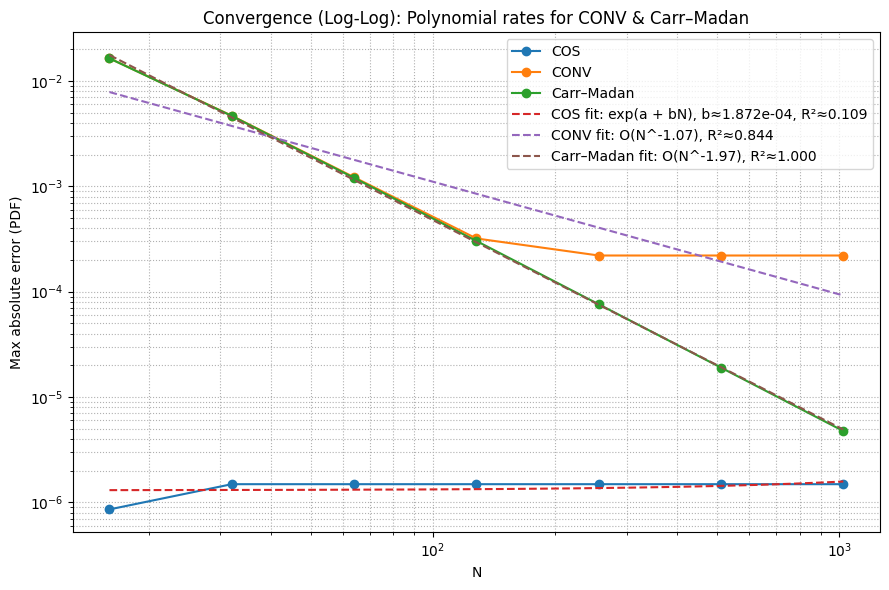


=== Empirical Convergence Summary ===
COS: last N=1024, error=1.487e-06, R²≈0.109
CONV: last N=1024, error=2.206e-04, R²≈0.844
Carr–Madan: last N=1024, error=4.753e-06, R²≈1.000


In [83]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import norm

# --- Pull your existing functions from the notebook environment ---
# Expected signatures:
#   cos_pdf2(a, b, N, chf, x) -> pdf on x
#   conv_pdf(chf, x_range=(-5,5), alpha=0.5, N=2**12) -> (x, pdf)
#   carr_madan_pdf(chf, x_range=(-5,5), N=2**12, ...) -> (x, pdf)
# or carr_madan_pdf(chf, x_grid, N=2**12, ...) -> pdf on x_grid

# --- Target CF: standard normal ---
def chf_normal(u):
    return np.exp(-0.5 * u**2)

# --- Common evaluation setup ---
x_range = (-5.0, 5.0)
grid_points = 2001
x_true = np.linspace(x_range[0], x_range[1], grid_points)
true_pdf = norm.pdf(x_true)

# --- Method runners that return (x, pdf) ---
def run_cos(N):
    a, b = x_range
    x = np.linspace(a, b, grid_points)
    pdf = cos_pdf2(a=a, b=b, N=N, chf=chf_normal, x=x)  # returns pdf-on-x
    return x, pdf

def run_conv(N, alpha=0.5):
    return conv_pdf(chf=chf_normal, x_range=x_range, alpha=alpha, N=N)

def run_cm(N):
    """Carr–Madan robust wrapper handling either x_range or x_grid signature."""
    # Preferred path: function returns (x, pdf) when given x_range
    try:
        x, pdf = carr_madan_pdf(chf=chf_normal, x_range=x_range, N=N)
        return x, pdf
    except TypeError:
        # Fallback: function expects an x grid and returns pdf on it
        x = np.linspace(x_range[0], x_range[1], grid_points)
        pdf = carr_madan_pdf(chf=chf_normal, x_grid=x, N=N)  # or carr_madan_pdf(chf, x, N=N)
        return x, pdf

methods = {
    "COS": lambda N: run_cos(N),
    "CONV": lambda N: run_conv(N, alpha=0.5),
    "Carr–Madan": lambda N: run_cm(N),
}

# --- N grids (powers of two) ---
N_values = np.array([16, 32, 64, 128, 256, 512, 1024])

# --- Compute errors ---
records = []
for name, runner in methods.items():
    for N in N_values:
        try:
            xN, pdfN = runner(int(N))
            # Interpolate to the common grid for fair comparison
            interp_pdf = np.interp(x_true, xN, pdfN)
            err = float(np.max(np.abs(interp_pdf - true_pdf)))
        except Exception as e:
            err = np.nan
        records.append({"Method": name, "N": int(N), "Error": err})

df = pd.DataFrame(records).sort_values(["Method", "N"]).reset_index(drop=True)

# --- Fits: COS exponential on semilog-y; others polynomial on log-log ---
def fit_exponential(N, err):
    """Fit ln(err) = a + b*N"""
    mask = np.isfinite(err) & (err > 0)
    if mask.sum() < 3:
        return np.nan, np.nan, np.nan
    X = N[mask].astype(float)
    y = np.log(err[mask])
    A = np.vstack([np.ones_like(X), X]).T
    coef, _, _, _ = np.linalg.lstsq(A, y, rcond=None)
    a, b = coef
    yhat = A @ coef
    ss_res = np.sum((y - yhat)**2)
    ss_tot = np.sum((y - y.mean())**2)
    r2 = 1 - ss_res / ss_tot if ss_tot > 0 else np.nan
    return a, b, r2

def fit_polynomial(N, err):
    """Fit ln(err) = c + p*ln(N)  ->  err ~ N^p (p<0)"""
    mask = np.isfinite(err) & (err > 0)
    if mask.sum() < 3:
        return np.nan, np.nan, np.nan
    X = np.log(N[mask].astype(float))
    y = np.log(err[mask])
    A = np.vstack([np.ones_like(X), X]).T
    coef, _, _, _ = np.linalg.lstsq(A, y, rcond=None)
    c, p = coef
    yhat = A @ coef
    ss_res = np.sum((y - yhat)**2)
    ss_tot = np.sum((y - y.mean())**2)
    r2 = 1 - ss_res / ss_tot if ss_tot > 0 else np.nan
    return c, p, r2

# Collect fits
fit_info = {}
for method in ["COS", "CONV", "Carr–Madan"]:
    sub = df[df["Method"] == method]
    if method == "COS":
        a, b, r2 = fit_exponential(sub["N"].values, sub["Error"].values)
        fit_info[method] = {"a": a, "b_exp_slope": b, "R2": r2}
    else:
        c, p, r2 = fit_polynomial(sub["N"].values, sub["Error"].values)
        fit_info[method] = {"c": c, "p_order": p, "R2": r2}

# --- Plot: log-log ---
plt.figure(figsize=(9, 6))


for name in ["COS", "CONV", "Carr–Madan"]:
    sub = df[df["Method"] == name].dropna()
    if len(sub):
        plt.loglog(sub["N"].values, sub["Error"].values, marker='o', label=name)

# COS exponential fit overlay
cos_sub = df[df["Method"] == "COS"].dropna()
a, b, r2 = fit_info["COS"]["a"], fit_info["COS"]["b_exp_slope"], fit_info["COS"]["R2"]
if np.isfinite(a) and np.isfinite(b):
    N_dense = np.linspace(N_values.min(), N_values.max(), 400)
    plt.semilogy(N_dense, np.exp(a + b*N_dense), linestyle='--',
                 label=f"COS fit: exp(a + bN), b≈{b:.3e}, R²≈{r2:.3f}")
# Overlay polynomial fits for CONV and CM
for name in ["CONV", "Carr–Madan"]:
    c, p, r2 = fit_info[name]["c"], fit_info[name]["p_order"], fit_info[name]["R2"]
    if np.isfinite(c) and np.isfinite(p):
        N_dense = np.linspace(N_values.min(), N_values.max(), 400)
        plt.loglog(N_dense, np.exp(c + p*np.log(N_dense)), linestyle='--',
                   label=f"{name} fit: O(N^{p:.2f}), R²≈{r2:.3f}")

plt.xlabel("N")
plt.ylabel("Max absolute error (PDF)")
plt.title("Convergence (Log-Log): Polynomial rates for CONV & Carr–Madan")
plt.grid(True, which="both", ls=":")
plt.legend()
plt.tight_layout()
plt.show()

# --- Print summary table of last point and fit diagnostics ---
print("\n=== Empirical Convergence Summary ===")
for name in ["COS", "CONV", "Carr–Madan"]:
    sub = df[df["Method"] == name].dropna()
    lastN = int(sub["N"].values[-1]) if len(sub) else None
    lastErr = float(sub["Error"].values[-1]) if len(sub) else np.nan
    if name == "COS":
        print(f"{name}: last N={lastN}, error={lastErr:.3e}, R²≈{fit_info[name]['R2']:.3f}")
    else:
        print(f"{name}: last N={lastN}, error={lastErr:.3e}, R²≈{fit_info[name]['R2']:.3f}")


#### Where can we make use of COS method?

- Calibration of option pricing models with analytical or semi-analytical characteristic function (recent research: rough volatility models).

- Analytical calculation of Greeks.

- Calculation of credit portfolio loss distribution (Economic Capital, Default Risk Charge).

- Counterpart credit risk (CCR) and XVA.

- Training deep neural netweorks to accelerate pricing/caliration.

- Solving portfolio optimisation problems (see {cite:p}`BrandtGoyal2005`).